In [1]:
import numpy as np
import functions as fc
import fourier_continuation as fc_c
from timeit import default_timer as time
from fatiando.gravmag import polyprism, sphere
from fatiando import mesher, gridder,utils
from fatiando.constants import G, SI2MGAL
from scipy.sparse import diags
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from scipy import interpolate
from fatiando.vis import mpl
import cPickle as pickle
%matplotlib inline

/home/vanderlei/Documents/fatiando/fatiando/vis/mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


## Create the model

In [2]:
# Polygonal Prism model
verts1 = [[-500, -3000], [0, -3500], [4500, 0], [4000, 500]]
verts2 = [[4000, -3000], [4500, -2500], [0, 3500], [-500, 3000]]

model_prism = [mesher.PolygonalPrism(verts1, 900., 1500., props={'density':1000}),
               mesher.PolygonalPrism(verts2, 1600., 2200., props={'density':1300})]
R = 1000 #Radius
xc, yc, zc = -3000.,0.,2000. #Center of sphere
model_sphere = [mesher.Sphere(xc, yc, zc,R, props={'density':-1250})]

## Grid and Forward model

In [3]:
# Create a regular grid at 0m height
shape = (100, 100)
area = [-5000, 5000, -4000, 4000]
xi, yi, zi = gridder.regular(area, shape, z=-100.)
print (area[1]-area[0])/(shape[0]-1.)

# Vertical component of the gravitational atraction observed
dobs_prism = polyprism.gz(xi, yi, zi, model_prism)
dobs_sphere = sphere.gz(xi, yi, zi, model_sphere)
dobs_0 = dobs_sphere + dobs_prism
dobs_low = utils.contaminate(dobs_0, 0.05, seed=0)
dobs_med = utils.contaminate(dobs_0, 0.1, seed=0)
dobs_high = utils.contaminate(dobs_0, 0.3, seed=0)

101.01010101


In [4]:
print 0.05/(np.max(dobs_0)-np.min(dobs_0))
print 0.1/(np.max(dobs_0)-np.min(dobs_0))
print 0.3/(np.max(dobs_0)-np.min(dobs_0))

0.0035731292261215407
0.0071462584522430815
0.021438775356729244


## True upward data

In [5]:
xi, yi, zi_up = gridder.regular(area, shape, z=-300.)

# True upward continuation of the gravitational atraction observed data
dobs_prism_up = polyprism.gz(xi, yi, zi_up, model_prism)
dobs_sphere_up = sphere.gz(xi, yi, zi_up, model_sphere)
dobs_up = dobs_sphere_up + dobs_prism_up

## True downward data

In [6]:
xi, yi, zi_down = gridder.regular(area, shape, z=-50.)

#Vertical component of the gravitational atraction observed downward
dobs_prism_down = polyprism.gz(xi, yi, zi_down, model_prism)
dobs_sphere_down = sphere.gz(xi, yi, zi_down, model_sphere)
dobs_down = dobs_sphere_down + dobs_prism_down

## Save the data

In [7]:
dobs = dict()
dobs['x'] = xi
dobs['y'] = yi
dobs['z'] = zi
dobs['z_up'] = zi_up
dobs['z_down'] = zi_down
dobs['gz_low'] = dobs_low
dobs['gz_med'] = dobs_med
dobs['gz_high'] = dobs_high
dobs['gz_up'] = dobs_up
dobs['gz_down'] = dobs_down

In [8]:
# common limits for all data
gz_min = np.min([dobs_low, dobs_med, dobs_high, dobs_up, dobs_down])
gz_max = np.max([dobs_low, dobs_med, dobs_high, dobs_up, dobs_down])

In [9]:
dobs['gz_min'] = gz_min
dobs['gz_max'] = gz_max

In [10]:
#save the data
file_name = 'synthetic_gz.pickle'
with open(file_name, 'w') as f:
    pickle.dump(dobs, f)

## Test pickle file

In [11]:
with open('synthetic_gz.pickle') as r:
    synthetic_gz = pickle.load(r)
    
dobs['z_down']

array([-50., -50., -50., ..., -50., -50., -50.])

## True data plot

In [ ]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc + R*np.cos(phi)
y = yc + R*np.sin(phi)

x_p = [-3000., -3500,0,500,-3000.]
y_p = [-500., 0,4500,4000,-500.]

x_p2 = [-3000, -2500,3500,3000,-3000.]
y_p2 = [4000, 4500,0,-500,4000]

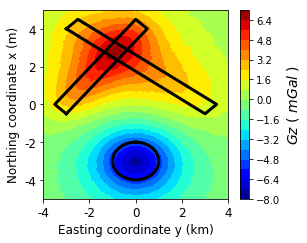

In [18]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(4.33,4.33*0.8))

plt.plot()
plt.tricontourf(yi,xi,dobs['gz_low'],22,cmap='jet',vmin=dobs['gz_min'],vmax=dobs['gz_max'])
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('Gravity data (mGal)', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/synthetic_data_low.png', dpi=1200)

In [ ]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))

plt.plot()
plt.tricontourf(yi,xi,dobs['gz_med'],22,cmap='jet',vmin=dobs['gz_min'],vmax=dobs['gz_max'])
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/synthetic_data_med.png', dpi=300)

In [ ]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))

plt.plot()
plt.tricontourf(yi,xi,dobs['gz_high'],22,cmap='jet',vmin=dobs['gz_min'],vmax=dobs['gz_max'])
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/synthetic_data_high.png', dpi=300)

In [ ]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))

plt.plot()
plt.tricontourf(yi,xi,dobs['gz_up'],22,cmap='jet',vmin=dobs['gz_min'],vmax=dobs['gz_max'])
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/synthetic_data_up.png', dpi=300)

In [ ]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))

plt.plot()
plt.tricontourf(yi,xi,dobs['gz_down'],22,cmap='jet',vmin=dobs['gz_min'],vmax=dobs['gz_max'])
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/synthetic_data_down.png', dpi=300)